<h1><center> Montel Carlo Implementation on Call Option Pricing</center></h1>
<h3><center>By: Tyler Trzecki</center></h3>
<hr>
This notebook is adapted from the Medium article ["Monte Carlo Simulation Engine In Python"](https://medium.com/fintechexplained/monte-carlo-simulation-engine-in-python-a1fa5043c613).

The notebook covers the implementation of a Monte Carlo Simulation to price a call option.


We begin with a portfolio with one European call option (European call options can only be exercised on their expiry date). 

1. First calculate the price of the option usingthe closed-form Black-Scholes formula as a benchmark.  


2. Then build the Monte-Carlo Simulation. Calculate the price *S* over 2000 scenarios. Assuming drift and volatility are constant for a basic simulation. Generate a random variable to simulate the uncertainty assuming a normal distribution.  


3. Calculate the payoff of the option for each scenario where the payoff is calculated as:

$$P = Max(S(t)-K,0)$$

- Where $S(t)$ is stock, S, at time t.


4. Sum the payoffs and discount them at the risk free rate because are generating the stock price at the maturity date using continous discounting.  


5. Caculate the price of the option from the discounted sum of payoffs. Caculate the average of teh discounted sum of payoffs generated for each scenario.  

## <center>Stochastic Calculus</center>

### Key Terms

#### Markov Processes

Prices of financial transactions follow a random walk. This random walk is known as a Markov process. It indicates that the process is stochastic in nature and the future price values are only dependent on the current price.

#### Wiener Process

If we assess a variable that follows a random walk and its change is measured over the time interval t, Wiener process is a variable that has its mean change as 0 and the variance of the variable is proportional to the time interval. The increments of the variable across time are not dependent on each other. It can be written as:

$$\varepsilon \sqrt{\Delta t}$$

- Where $\varepsilon$ is a standard normal variable with mean 0 and variance 1

#### Generalized Wiener Process

The generalized wiener process is a variable that not only behaves like a Wiener process but also has a constant trend per unit of time and a constant volatility.

#### Ito Process

This brings us to the Ito process. It is essentially a generalized wiener process except that its trend and volatility is dependent on the time and the present value of the underlying variable. This is a Markov process as the past does not matter in Ito process. It can be written as:

$$\delta S(t) = \text{Drift} + \text{Uncertainty}$$

Wiener-process is also known as Brownian motion. Geometric Brownian motion is the exponential of the Wiener-process with drift. Geometric Brownian Motion (GBM) is an example of Ito’s process. GBM for a variable S can be written as:

$$\delta S(t) = S(t)\mu\delta t + S(t)\sigma\sqrt{\Delta t \varepsilon}$$

- Where $\sigma$ is the volatility.

The GBM process is basic in nature because it does not incorporate mean-reversion and time-dependent volatility. As a consequence, GBM is not consistent with bond prices that display long term reversion to the face value.

As the name implies, the process is geometric in nature because the drift and volatility are proportional to the current value of S.   


>**The goal of the Monte Carlo simulation is to calculate the process ofthe option by simulating the stochastic Wiener Process.**


Our model is assumed to be risk neutral. The risk neutral approach is when the price of an option on a stock grows at the same risk free rate as the risk free rate which is used to discount it.


Ito Lemma rule calculates the differential of a variable as a function of time and a stochastic process. Therefore the solution of the stochastic differential equation of GBM by using Ito’s lemma is:

$$S(t) = S(0)\exp{[(r - 0.5\sigma^2)t + \sigma\sqrt{t\varepsilon}]}$$

- Where $\varepsilon$ is random variable with standard normal distribution N(0,1)

The program will be modeled as the following:

#### 1.  MonteCarloEngineSimulator

MonteCarloEngineSimulator is a class responsible for:

    1. Calling the simulation model to simulate the risk factor which is the stock price.
    
    2. Pass the risk factor values to the trade payoff pricer to value the trade.
    
#### 2. GBMModel

GBMModel class will contain the GBM stochastic differential equation which is outlined above. It takes in a trade and generates stock prices.

#### 3. OptionTradePayoffPricer

OptionTradePayoffPricer class will take in the trade as a parameter and it will generate an average call option payoff.

#### 4. OptionTrade

A class to store the information of the trade such as stock price, initial price, risk free rate, and underlying stock volatility.

#### 5. Scenarios

A class to store the information for the number of scenarios and timesteps.

#### 6. Future Considerations

Add classes for SwapTrade and AmericanCallOptionTrade to expand the capabilities.



In [13]:
import numpy as np
import matplotlib.pyplot as plt

In [14]:
class Configuration:
    def __init__(self, NumScenarios, NumTimesteps):
        self.NumScenarios = NumScenarios
        self.NumTimesteps = NumTimesteps

In [22]:
class OptionTrade:
    def __init__(self, stock_price, strike_price, risk_free,volt,maturity):
        self.stock_price = stock_price
        self.strike_price = strike_price
        self.risk_free = risk_free
        self.volt = volt
        self.maturity = maturity

In [16]:
class GBMModel:
    def __init__(self, Configuration):
        self.Configuration = Configuration
    
    #Simulate risk factors using GBM stochastic differential equation
    def SimulateRiskFactor(self,trade):
        prices = []
        #For a European Call option we are only concerned with one timestep
        timestep = 1
        for scenarioNumber in range(self.Configuration.NumScenarios):
            normal_random_num = np.random.normal(0,1)
            drift = (trade.risk_free - 0.5 * trade.volt**2) * timestep
            
            uncertainty = trade.volt * np.sqrt(timestep) * normal_random_num
            
            price = trade.stock_price * np.exp(drift+uncertainty)
            prices.append(price)
        
        return prices
        

In [17]:
class OptionTradePayoffPricer:
    def calculatePrice(self, trade, prices_per_scenario):
        payoffs = 0
        total_scenarios = len(prices_per_scenario)
        
        for i in range(total_scenarios):
            price = prices_per_scenario[i]
            payoff = price - trade.strike_price
            
            if payoff > 0:
                payoffs = payoffs + payoff
        
        discounted_price = np.exp(-1.0 * trade.risk_free * trade.maturity) * payoffs
        
        result = discounted_price / total_scenarios
        return result

In [18]:
def plot_scenario_paths(prices_per_scenario, trade):
    x = []
    y = []
    
    for i in prices_per_scenario:
        y.append(i)
        y.append(trade.stock_price)
        x.append(1)
        x.append(0)
        plt.plot(x,y)
        
    plt.ylabel('Stock Value')
    plt.xlabel('Timestep')
    plt.show()

In [25]:
class MonteCarloEngineSimulator:
    
    #instantiate with Configuration and model classes
    def __init__(self, Configuration, model):
        self.Configuration = Configuration
        self.model = model
        
    # simulate trade and calculate prices
    def Simulate(self, trade, tradePricer):
        prices_per_scenario = self.model.SimulateRiskFactor(trade)
        
        #plot scenarios
        plot_scenario_paths(prices_per_scenario,trade)
        
        price = tradePricer.calculatePrice(trade, prices_per_scenario)
        
        return price

### Step 1. Price an option with Black-Scholes Formula

Price an option with the following information:

- Stock spot price: 200
- Strike price: 200
- Time to maturity: 1 year
- Volatility: 10%
- Risk Free Rate: 15%

The information yields the call option price of **$28.40** as a **benchmark value**.

### Step 2.1 Price the option with the Monte Carlo simulation using 10 scenarios:


In [37]:
def Main10():
    #prepare the data
    configuration = Configuration(10, 1) # config
    trade = OptionTrade(200, 200, 0.15, 0.1,1) # trade
    model = GBMModel(configuration)
    tradePricer = OptionTradePayoffPricer()
    simulator = MonteCarloEngineSimulator(configuration, model)
    
    #simulate price
    price = simulator.Simulate(trade, tradePricer)
    print("The simulated price of the call option is ${}".format(round(price,4)))

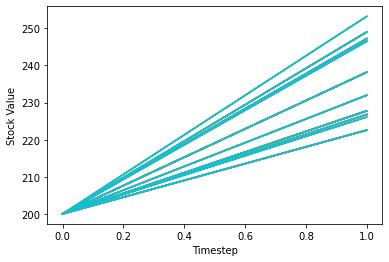

The simulated price of the call option is $31.8106


In [38]:
Monte10 = Main10()

### Step 2.1 Price the option with the Monte Carlo simulation using 100 scenarios:


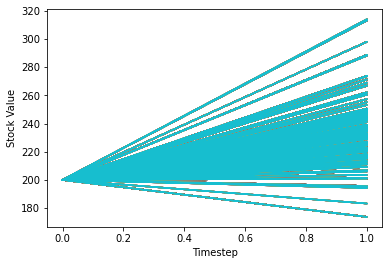

The simulated price of the call option is $30.921


In [39]:
def Main100():
    #prepare the data
    configuration = Configuration(100, 1) # config
    trade = OptionTrade(200, 200, 0.15, 0.1,1) # trade
    model = GBMModel(configuration)
    tradePricer = OptionTradePayoffPricer()
    simulator = MonteCarloEngineSimulator(configuration, model)
    
    #simulate price
    price = simulator.Simulate(trade, tradePricer)
    print("The simulated price of the call option is ${}".format(round(price,4)))

Monte100 = Main100()

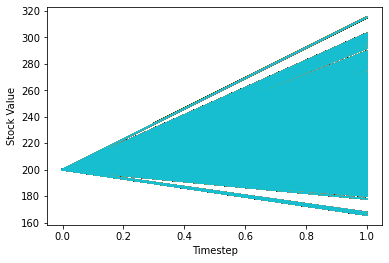

The simulated price of the call option is $29.1454


In [40]:
def Main1000():
    #prepare the data
    configuration = Configuration(1000, 1) # config
    trade = OptionTrade(200, 200, 0.15, 0.1,1) # trade
    model = GBMModel(configuration)
    tradePricer = OptionTradePayoffPricer()
    simulator = MonteCarloEngineSimulator(configuration, model)
    
    #simulate price
    price = simulator.Simulate(trade, tradePricer)
    print("The simulated price of the call option is ${}".format(round(price,4)))

Monte1000 = Main1000()